# Is our generic dgemm model realistic?

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    dgemm_model = get_yaml(name, dgemm_file[0])
    generic = 'experiment_date' not in dgemm_model['info']
    result['generic'] = generic
    return result

simulation_dir = 'generic_model/1/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,simulation_time,application_time,usr_time,sys_time,major_page_fault,minor_page_fault,cpu_utilization,platform,filename,generic
0,300000,128,32,32,1,2,2,1,0,8,...,6678.21,776.111,5475.66,1188.68,0,564480955,0.99,dahu.xml,generic_model/1/nancy_2020-02-14_2279976.zip,False
1,500000,128,32,32,1,2,2,1,0,8,...,14800.20,1523.630,10800.01,3964.25,0,2201365937,0.99,dahu.xml,generic_model/1/nancy_2020-02-14_2279976.zip,False
2,100000,128,32,32,1,2,2,1,0,8,...,1727.91,263.348,1542.24,184.19,0,52019856,0.99,dahu.xml,generic_model/1/nancy_2020-02-14_2279976.zip,False
3,200000,128,32,32,1,2,2,1,0,8,...,3972.07,524.100,3350.80,614.14,0,261097254,0.99,dahu.xml,generic_model/1/nancy_2020-02-14_2279976.zip,False
4,400000,128,32,32,1,2,2,1,0,8,...,10022.30,1078.560,7856.64,2144.83,0,1100174514,0.99,dahu.xml,generic_model/1/nancy_2020-02-14_2279976.zip,False


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,swap,rfact,process_per_node,proc_q,generic,mem_align,bcast,block_size,pfact,proc_p,depth,thread_per_process
0,0,2,32,32,False,8,2,128,1,32,1,1
0,0,2,32,32,True,8,2,128,1,32,1,1


In [3]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the simulation

In [4]:
patches = set()
for row in df.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

## Impact on the predicted HPL performance

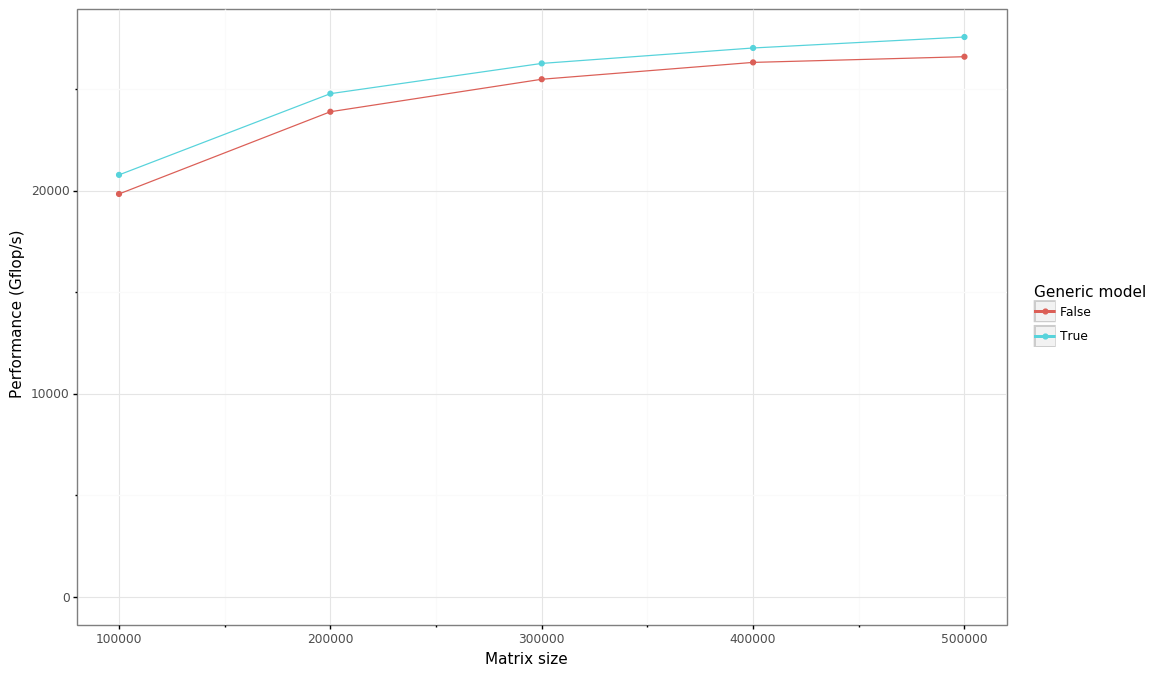

<ggplot: (8752611114921)>

In [5]:
ggplot(df) +\
    aes(x='matrix_size', y='gflops', color='generic') +\
    geom_point() +\
    geom_line() +\
    xlab('Matrix size') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='Generic model') +\
    expand_limits(y=0) +\
    theme_bw()

## Impact on the simulation time

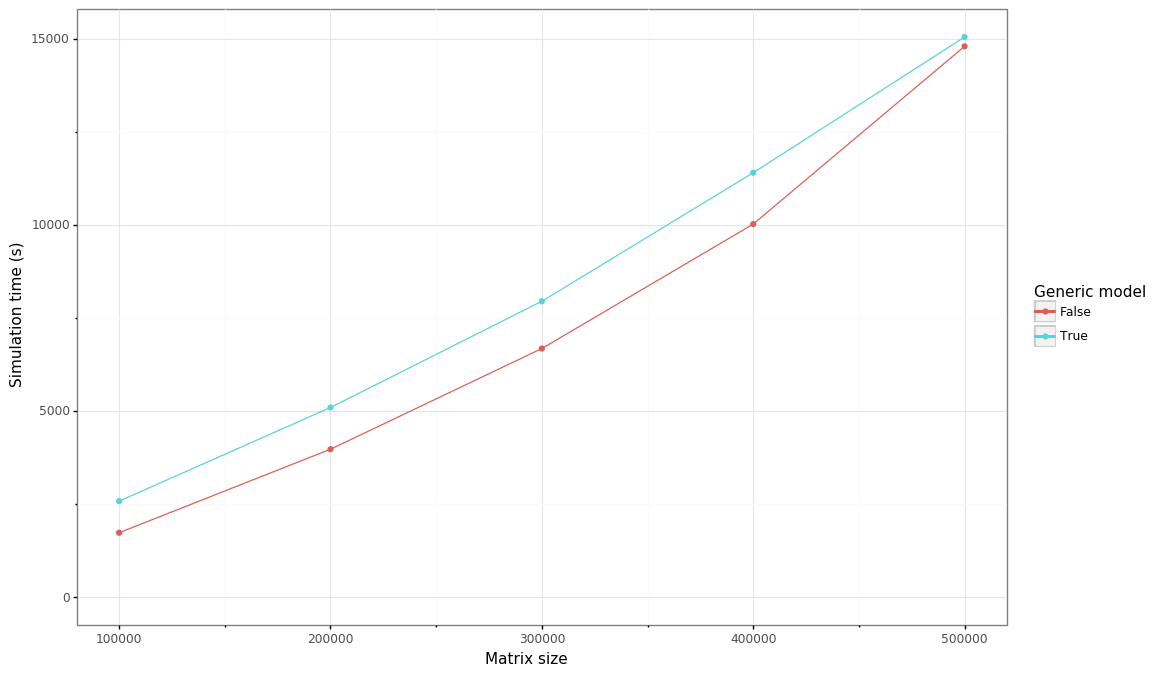

<ggplot: (-9223363284337800269)>


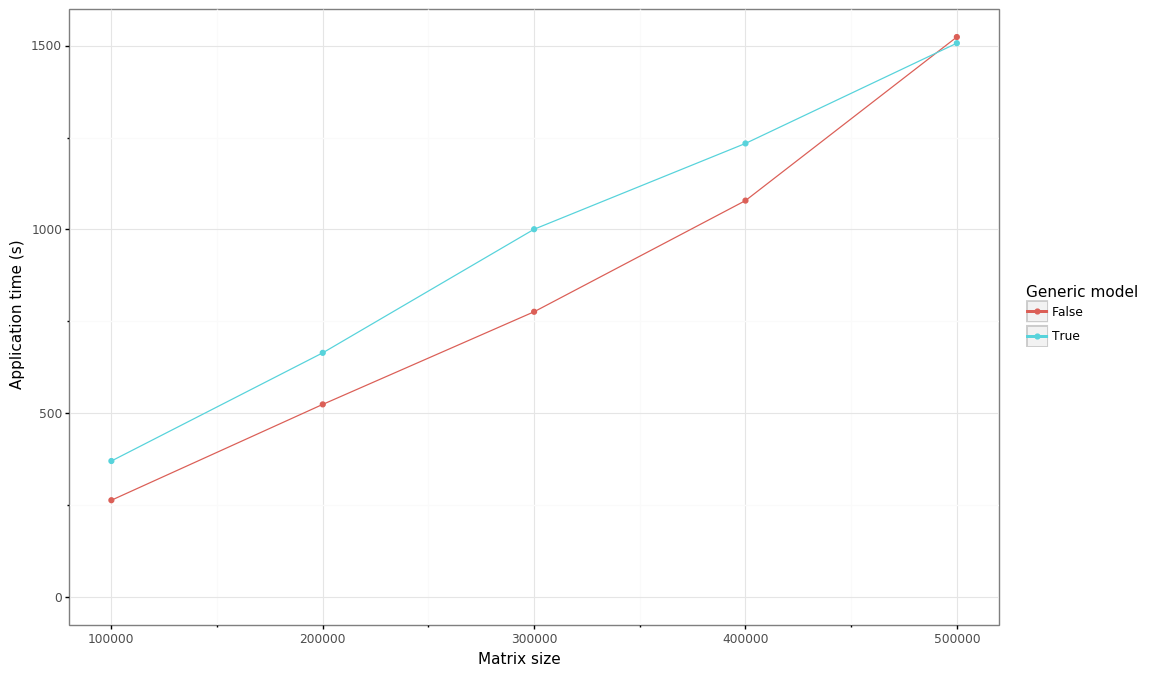

<ggplot: (-9223363284337797218)>


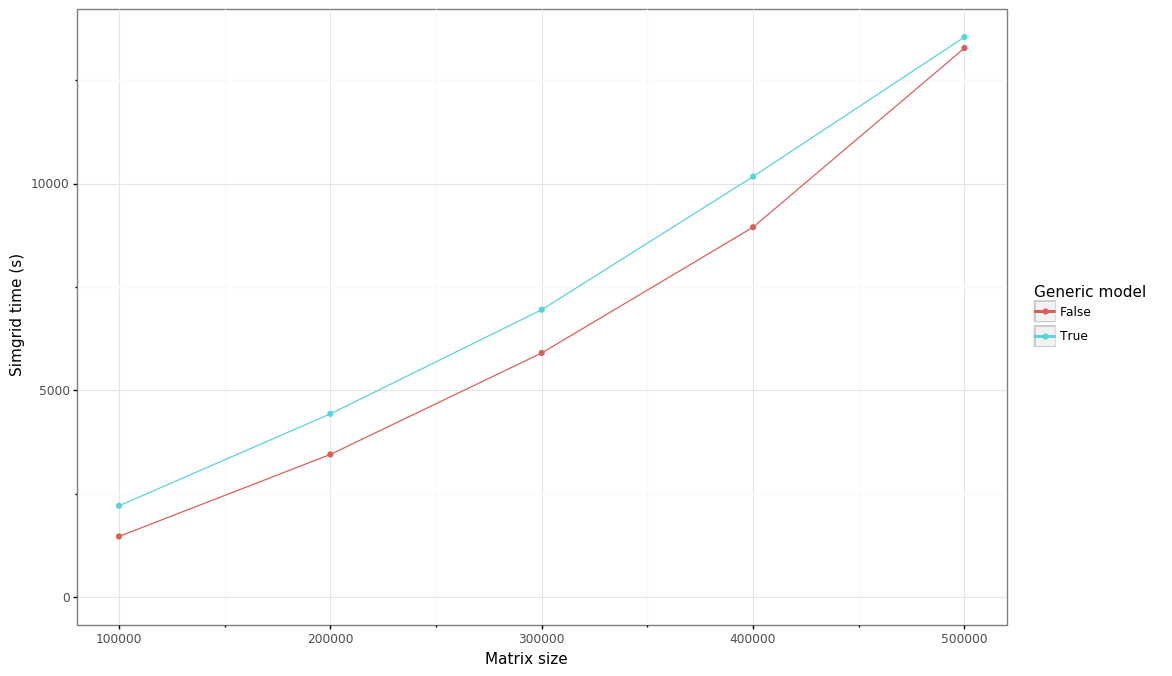

<ggplot: (8752516975806)>


In [6]:
df['simgrid_time'] = df['simulation_time'] - df['application_time']

plot = ggplot(df) +\
    aes(x='matrix_size', color='generic') +\
    geom_point() +\
    geom_line() +\
    xlab('Matrix size') +\
    ylab('Simulation time (s)') +\
    labs(color='Generic model') +\
    theme_bw() +\
    expand_limits(y=0)

for y in ['Simulation', 'Application', 'Simgrid']:
    print(plot + aes(y='%s_time' % y.lower()) + ylab('%s time (s)' % y))